#Loading Dataset

In [0]:
!pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"writammallik","key":"e5e3703be39ae2165480979852bc602d"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 94% 187M/199M [00:04<00:00, 54.6MB/s]
100% 199M/199M [00:04<00:00, 50.5MB/s]


In [0]:
from zipfile import ZipFile

file_name = "/content/ravdess-emotional-speech-audio.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


#Importing Dependencies

In [0]:
import glob  
import os  
import librosa  
import numpy as np  
from keras.models import Sequential  
from keras.layers import Dense, Activation  
from keras.layers import Dropout  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt

Using TensorFlow backend.


#Feature Extraction

In [0]:
def extract_feature(file_name): 
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

In [0]:
def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    features = np.empty((0,193))
    labels=[]
    for label, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
              mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            except Exception as e:
              print ("Error encountered while parsing file: ", fn)
              continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            labels.append(fn.split('/')[3].split('-')[2])
    return np.array(features), np.array(labels, dtype = np.int)

In [0]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels+1))
    one_hot_encode[np.arange(n_labels), labels] = 1
    one_hot_encode=np.delete(one_hot_encode, 0, axis=1)
    return one_hot_encode

In [0]:
main_dir = "/content" 
sub_dir=os.listdir(main_dir)  
sub_dir.remove('.config')
sub_dir.remove('kaggle.json')
sub_dir.remove('ravdess-emotional-speech-audio.zip')
sub_dir.remove('sample_data')
print ("\ncollecting features and labels...")  
print("\nthis will take some time...")  
features, labels = parse_audio_files(main_dir,sub_dir)  
print("done")  
np.save('X',features)  
#one hot encoding labels  
labels = one_hot_encode(labels)  
np.save=('y', labels)


collecting features and labels...

this will take some time...
done


In [0]:
labels.shape

(1440, 8)

In [0]:
features.shape

(1440, 193)

In [0]:
X=np.load('X.npy')  
#X = fetures
#y=np.load('y.npy') 
y=labels 
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [0]:
train_x.shape

(964, 193)

In [0]:
train_y.shape

(964, 8)

#Building Model

In [0]:
n_dim = train_x.shape[1]  
n_classes = train_y.shape[1]  
n_hidden_units_1 = n_dim  
n_hidden_units_2 = 400            # approx n_dim * 2  
n_hidden_units_3 = 200            # half of layer 2  
n_hidden_units_4 = 100

In [0]:
def create_model(activation_function='relu', init_type='normal', optimiser='adam', dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(n_hidden_units_1, input_dim=n_dim, init=init_type, activation=activation_function))
    model.add(Dense(n_hidden_units_2, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_hidden_units_3, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_hidden_units_4, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, init=init_type, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

In [0]:
model = create_model()  
history = model.fit(train_x, train_y, epochs=200, batch_size=4)

W0830 10:13:13.887290 139834460292992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, input_dim=193, activation="relu", kernel_initializer="normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0830 10:13:13.940941 139834460292992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 10:13:13.947776 139834460292992 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4409: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

/usr/l

Epoch 1/200
964/964 [==============================] - 6s 6ms/step - loss: 2.2695 - acc: 0.1473
Epoch 2/200
964/964 [==============================] - 1s 2ms/step - loss: 1.9870 - acc: 0.2023
Epoch 3/200
964/964 [==============================] - 1s 2ms/step - loss: 1.8948 - acc: 0.2365
Epoch 4/200
964/964 [==============================] - 2s 2ms/step - loss: 1.8397 - acc: 0.2573
Epoch 5/200
964/964 [==============================] - 1s 2ms/step - loss: 1.8063 - acc: 0.2832
Epoch 6/200
964/964 [==============================] - 2s 2ms/step - loss: 1.7782 - acc: 0.3029
Epoch 7/200
964/964 [==============================] - 2s 2ms/step - loss: 1.7306 - acc: 0.3185
Epoch 8/200
964/964 [==============================] - 2s 2ms/step - loss: 1.7037 - acc: 0.3122
Epoch 9/200
964/964 [==============================] - 2s 2ms/step - loss: 1.6959 - acc: 0.3361
Epoch 10/200
964/964 [==============================] - 2s 2ms/step - loss: 1.6290 - acc: 0.3506
Epoch 11/200
964/964 [=================

#Model Prediction

In [0]:
predict=model.predict(test_x,batch_size=4)

In [0]:
predict.shape

(476, 8)

In [0]:
emotions=['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  

y_pred = np.argmax(predict, 1)  
predicted_emo=[]   
for i in range(0,test_y.shape[0]):  
  emo=emotions[y_pred[i]]  
  predicted_emo.append(emo)

In [0]:
actual_emo=[]  
y_true=np.argmax(test_y, 1)  
for i in range(0,test_y.shape[0]):  
  emo=emotions[y_true[i]]  
  actual_emo.append(emo)

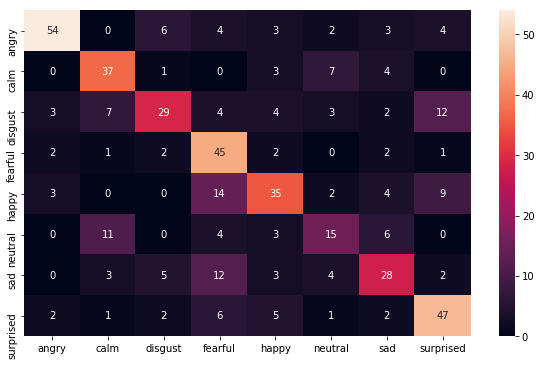

In [0]:
cm =confusion_matrix(actual_emo, predicted_emo)  
index = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']  
columns = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']  
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True)  